# Set up 

Set up of the random number generator and general libraries and configurations

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 

torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

56


# Choice of data and system

Options are: the moon system (2D), the Toggle Switch (2D) and the repressilator (3D)

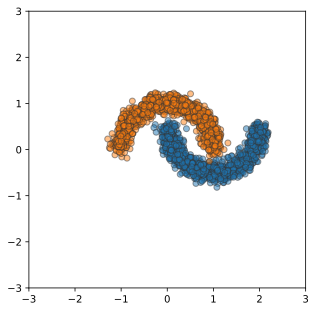

In [19]:
# design choices 
chosen_problem = 'moons'


possible_problem = {'moons':'moons', 'ToggleSwitch':'TS', 'repressilator':'repr'} 
# this choices determine the data set that we build and subsequent choices on the construction of the neural ODE 
# - in particular, it determines the dimensions 
problem = possible_problem[chosen_problem]

data_noise = 0.00
if problem == 'moons':
    plotlim = [-3, 3]
    data_noise = 0.10
else:
    plotlim = [0, 2]
subfolder = str('traj_'+problem)

from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader(problem, batch_size = 3000, noise = data_noise, 
                                               plotlim = plotlim, random_state = seed, label = 'vector')

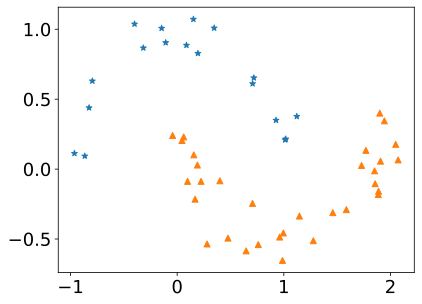

In [34]:
import matplotlib.pyplot as plt


for X_viz, y_viz in dataloader:
    x = X_viz[0:50].numpy()
    y = y_viz[0:50].numpy()
    if problem == 'repr':
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(x[:,0], x[:,1], x[:,2], marker = '*')
        ax.scatter(y[:,0], y[:,1], y[:,2], marker='^')
    elif problem == 'moons':
        plt.scatter(x[y[:,0]==-2,0], x[y[:,0]==-2,1], marker = '*')
        plt.scatter(x[y[:,0]==2,0], x[y[:,0]==2,1], marker = '^')
    else:
        plt.scatter(x[:,0], x[:,1], marker = '*')
        plt.scatter(y[:,0], y[:,1], marker = '^')
    plt.show()
    break

# nODE parameter choices

In [26]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 1
# num_steps = 1 is autonomous dynamics
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

# non_linearity = 'tanh' #'relu' #
# architecture = 'inside' #outside

non_linearity='tanh'
architecture='inside'

num_epochs = 80 #number of optimization runs in which the dataset is used for gradient decent
# eps = 0.2 # doesn't seem to be used anywhere

In [26]:
# for neural ODE based networks the network width is constant. In these examples the input is 2 or 3 dimensional
# possible_problem = {'moon':'moon', 'ToggleSwitch':'TS', 'repressilator':'repr'} 
if problem == 'moons' or problem == 'TS':
    hidden_dim, data_dim = 2, 2 
else:
    hidden_dim, data_dim = 3, 3 
augment_dim = 0

In [27]:
# resets the seed - allows for coherent runs in the gradient descent as well
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

in NeuralODE parameter dim = 2 data dim =  2
in Dynamics 2 parameter dim = 2 input dim =  2


# Training

In [28]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 1.576

Iteration 10/38
Loss: 1.793

Iteration 20/38
Loss: 1.311

Iteration 30/38
Loss: 1.415
Epoch 1: 1.527

Iteration 0/38
Loss: 1.292

Iteration 10/38
Loss: 1.346

Iteration 20/38
Loss: 1.187

Iteration 30/38
Loss: 1.063
Epoch 2: 1.282

Iteration 0/38
Loss: 1.138

Iteration 10/38
Loss: 1.164

Iteration 20/38
Loss: 1.084

Iteration 30/38
Loss: 1.063
Epoch 3: 1.157

Iteration 0/38
Loss: 1.020

Iteration 10/38
Loss: 1.136

Iteration 20/38
Loss: 1.013

Iteration 30/38
Loss: 0.916
Epoch 4: 1.074

Iteration 0/38
Loss: 1.092

Iteration 10/38
Loss: 1.017

Iteration 20/38
Loss: 1.004

Iteration 30/38
Loss: 0.932
Epoch 5: 1.007

Iteration 0/38
Loss: 0.898

Iteration 10/38
Loss: 1.079

Iteration 20/38
Loss: 1.021

Iteration 30/38
Loss: 0.865
Epoch 6: 0.964

Iteration 0/38
Loss: 0.938

Iteration 10/38
Loss: 0.949

Iteration 20/38
Loss: 0.839

Iteration 30/38
Loss: 0.857
Epoch 7: 0.945

Iteration 0/38
Loss: 0.958

Iteration 10/38
Loss: 0.956

Iteration 20/38
Loss: 1.041

Ite

Check for training

In [29]:
w = anode.linear_layer.weight
b = anode.linear_layer.bias
dt = anode.T/anode.time_steps   #here was no -1 before which does not fit with adjoint solver otherwise
k = int(T/dt)
#print(k)
w_t = anode.flow.dynamics.fc2_time[0].weight
b_t = anode.flow.dynamics.fc2_time[0].bias
print(w)
print(b)
print(anode.flow.dynamics.fc2_time)

Parameter containing:
tensor([[-6.6718e-01, -2.4728e-01],
        [ 6.8637e-08, -5.4416e-08]], requires_grad=True)
Parameter containing:
tensor([-2.9330e-01,  4.8272e-07], requires_grad=True)
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
)


In [ ]:
Showing the classification level sets, only makes sense in 2 dimensions

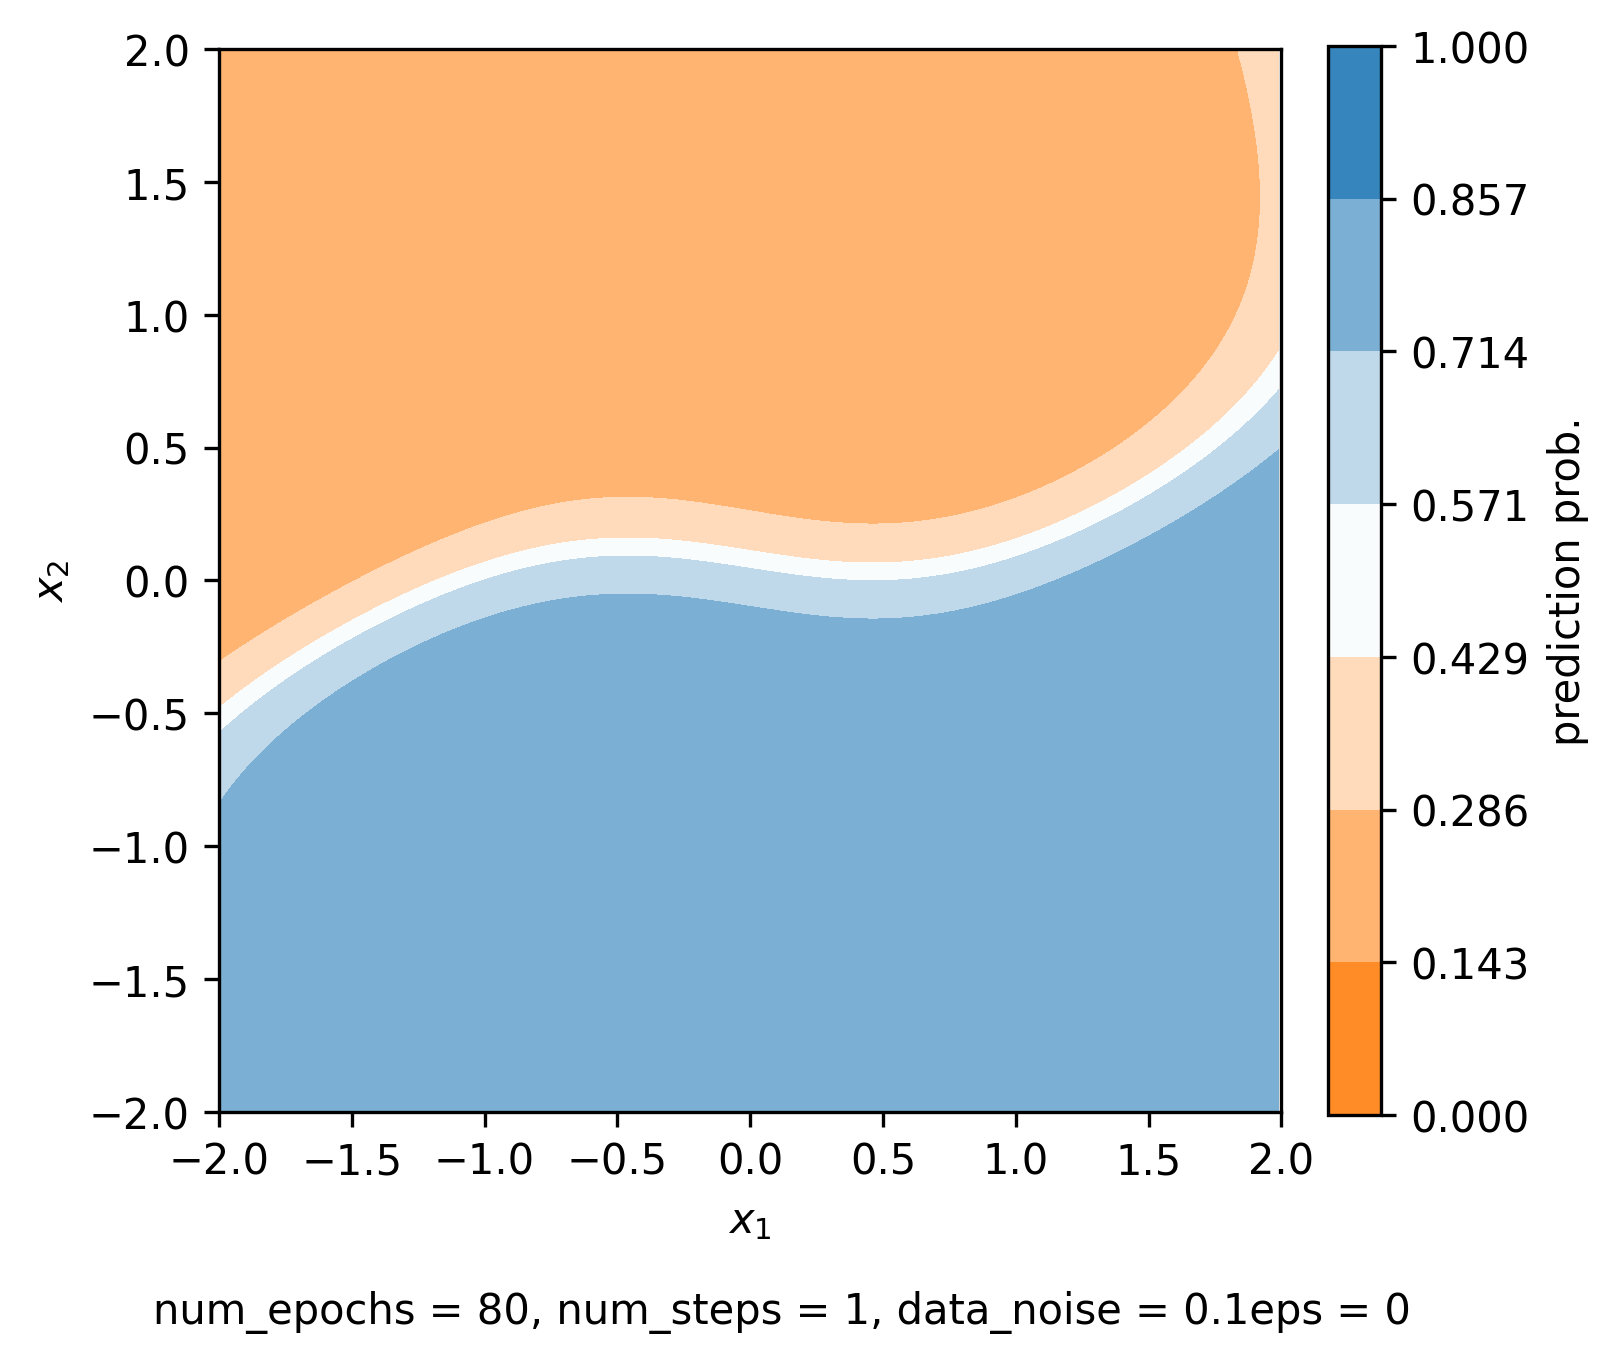

In [31]:
from plots.plots import classification_levelsets
from IPython.display import Image
import os


if data_dim == 2:
    if not os.path.exists(subfolder):
            os.makedirs(subfolder)
        
    footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'

    fig_name_base = os.path.join(subfolder, 'levelsets_TS')
    classification_levelsets(anode, fig_name_base, footnote = footnote + 'eps = 0')
    
    img1 = Image(filename = fig_name_base + '.png', width = 400)
    
    display(img1)

In [32]:
from plots.gifs import trajectory_gif
from IPython.display import Image

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory_TS.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory_TS.gif")
display(traj)

ValueError: The number of derivatives at boundaries does not match: expected 3, got 0+0

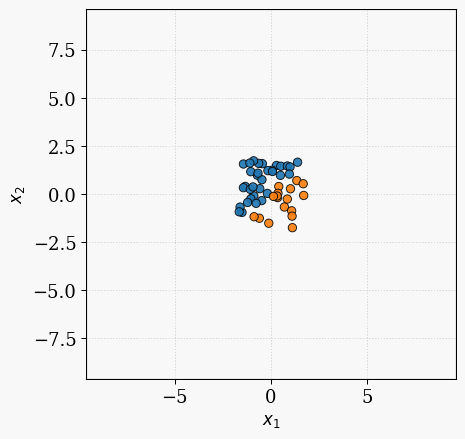

In [33]:
traj = Image(filename="trajectory_TS.gif")
display(traj)